In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Step 2: Import Pandas and Load TCS Stock Data
import pandas as pd

# Path to your dataset - **Please update this path with the correct location of your file**
file_path = '/content/drive/MyDrive/DL_Projects/3.Stock Price Prediction LSTM/TCS.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the first 5 rows
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624


In [5]:
# Step 1: Basic Info
print("Shape of data:", df.shape)
print("\nColumn Names:", df.columns)
print("\nData Types:\n", df.dtypes)

# Step 2: Check Missing Values
print("\nMissing values:\n", df.isnull().sum())

# Step 3: Drop unneeded columns
columns_to_drop = ['Symbol', 'Series', 'Prev Close', 'Last', 'VWAP',
                   'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']
df = df.drop(columns=columns_to_drop)

# Step 4: Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 5: Set 'Date' as index
df.set_index('Date', inplace=True)

# Step 6: Sort the index
df.sort_index(inplace=True)

# Step 7: Show cleaned data
df.head()


Shape of data: (4139, 15)

Column Names: Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

Data Types:
 Date                   object
Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                float64
Deliverable Volume      int64
%Deliverble           float64
dtype: object

Missing values:
 Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP             

,Open,High,Low,Close
Date,,,,
2004-08-25,1198.7,1198.7,979.00,987.95
2004-08-26,992.0,997.0,975.30,979.00
2004-08-27,982.4,982.4,958.55,962.65
2004-08-30,969.9,990.0,965.00,986.75
2004-08-31,986.5,990.0,976.00,988.10


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Use only the 'Close' column
close_data = df[['Close']].values  # Convert to NumPy array

# Step 2: Normalize the close prices between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Step 3: Define sequence length
sequence_length = 60  # use past 60 days to predict next

# Step 4: Create sequences (X) and corresponding labels (y)
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])  # last 60 values
    y.append(scaled_data[i, 0])                    # 61st value

# Step 5: Convert to numpy arrays and reshape for LSTM
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # [samples, time_steps, features]

# Step 6: Train-test split (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (3263, 60, 1)
X_test shape: (816, 60, 1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Initialize the model
model = Sequential()

# Step 2: Add first LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Step 3: Add second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Step 4: Add third LSTM layer with Dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Step 5: Output layer (1 neuron for 1 prediction)
model.add(Dense(units=1))

# Step 6: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Step 1: Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - loss: 0.0329 - val_loss: 0.0045
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 10/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 11/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 12/20
102/102 ━━━━━━━━━━━

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


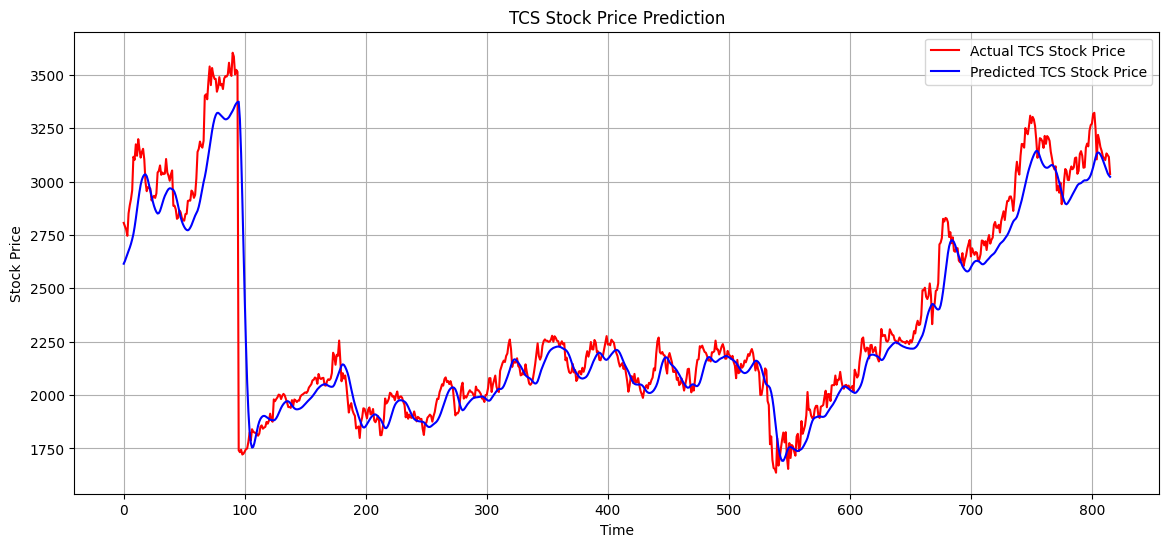

In [10]:
# Predicting on test data
predicted_stock_price = model.predict(X_test)

# Inverse scaling to get actual prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(real_stock_price, color='red', label='Actual TCS Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted TCS Stock Price')
plt.title('TCS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 151.9096761965173


In [14]:
# Take the last 60 days from the test data
last_60_days = scaled_data[-60:]  # Already scaled

# Reshape to match LSTM input
X_future = np.reshape(last_60_days, (1, 60, 1))

# Predict the next day's price
future_price_scaled = model.predict(X_future)

# Convert it back to original price using scaler
future_price = scaler.inverse_transform(future_price_scaled)

print(f"Predicted Closing Price for Next Day: ₹{future_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Closing Price for Next Day: ₹3014.85


In [15]:
future_days = 7
input_data = scaled_data[-60:]  # last 60 days from the scaled data
input_data = input_data.reshape(1, 60, 1)

future_predictions = []

for day in range(future_days):
    predicted_price = model.predict(input_data)[0][0]
    future_predictions.append(predicted_price)

    # Append this predicted value to the input, and remove the first value to maintain 60 window
    new_input = np.append(input_data[:, 1:, :], [[[predicted_price]]], axis=1)
    input_data = new_input

# Inverse transform to get actual price
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Predicted price on 7th future day:", future_predictions_actual[-1][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Predicted price on 7th future day: 2932.2747


In [16]:
# Step 1: Get the last 60 days of closing prices from the scaled data
last_60_days = scaled_data[-60:]

# Step 2: Make a list to hold predicted prices
future_predictions = []

# Step 3: Predict next 7 days
input_data = last_60_days.copy()

for _ in range(7):
    # Reshape to match model input shape: (1, 60, 1)
    input_reshaped = np.reshape(input_data, (1, 60, 1))

    # Predict the next closing price
    predicted_price = model.predict(input_reshaped, verbose=0)

    # Store predicted price
    future_predictions.append(predicted_price[0, 0])

    # Update input data: drop the first value, add the predicted one
    input_data = np.append(input_data[1:], predicted_price, axis=0)

# Step 4: Inverse transform to get actual price values (from scaled)
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Step 5: Display the predictions
for i, price in enumerate(future_predictions_actual, 1):
    print(f"Day {i} Predicted Close Price: ₹{price[0]:.2f}")


Day 1 Predicted Close Price: ₹3014.85
Day 2 Predicted Close Price: ₹3004.66
Day 3 Predicted Close Price: ₹2992.06
Day 4 Predicted Close Price: ₹2977.81
Day 5 Predicted Close Price: ₹2962.70
Day 6 Predicted Close Price: ₹2947.39
Day 7 Predicted Close Price: ₹2932.27


In [17]:
from keras.models import load_model
import os

# Step 1: Define the path in Google Drive where you want to save
save_path = "/content/drive/MyDrive/DL_Projects/3.Stock Price Prediction LSTM/stock_price_lstm_model.h5"

# Step 2: Save the model
model.save(save_path)

print("✅ Model saved successfully at:")
print(save_path)


✅ Model saved successfully at:
/content/drive/MyDrive/DL_Projects/3.Stock Price Prediction LSTM/stock_price_lstm_model.h5


In [18]:
app_code = """
import streamlit as st
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib

# Load model and scaler
model = tf.keras.models.load_model("stock_lstm_model.h5")
scaler = joblib.load("scaler.save")

# Title
st.title("📈 Stock Price Prediction using LSTM")

# Upload CSV
uploaded_file = st.file_uploader("Upload Stock Data (CSV)", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    st.subheader("Raw Uploaded Data")
    st.write(df.tail())

    # Only take 'Close' price
    data = df['Close'].values.reshape(-1, 1)
    scaled_data = scaler.transform(data)

    # Create input sequence (last 60 days)
    input_sequence = scaled_data[-60:]
    input_sequence = np.reshape(input_sequence, (1, 60, 1))

    # Predict for next 7 days
    predictions = []
    current_input = input_sequence.copy()

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)
        predictions.append(pred[0][0])
        current_input = np.append(current_input[:, 1:, :], [[pred]], axis=1)

    predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    st.subheader("📅 Predicted Stock Prices for Next 7 Days")
    for i, price in enumerate(predicted_prices):
        st.write(f"Day {i+1}: ₹{price[0]:.2f}")

    # Plot
    st.subheader("🔮 Forecast Plot")
    fig, ax = plt.subplots()
    ax.plot(range(1, 8), predicted_prices, marker='o')
    ax.set_title("7-Day Stock Price Forecast")
    ax.set_xlabel("Day")
    ax.set_ylabel("Price (INR)")
    st.pyplot(fig)
"""

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py file created in current Colab directory.")


✅ app.py file created in current Colab directory.


In [19]:
!ls



app.py	drive  sample_data


In [20]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00


In [23]:
# 1. Install dependencies (if not already installed)
!pip install streamlit pyngrok --quiet

# 2. Import libraries
from pyngrok import ngrok
import os

# 3. Write your Streamlit app to app.py
with open("app.py", "w") as f:
    f.write("""
import streamlit as st

st.set_page_config(page_title='Hello App', layout='centered')
st.title("🚀 Hello Streamlit")
st.write("This is a basic Streamlit app running on Google Colab with ngrok!")
""")

# 4. Set your ngrok authtoken (replace with your actual token)
!ngrok config add-authtoken 30PbGKl6xIlIz9R8zW0x4JKoiDB_6drmvLUGCGKvSaFMxvCZg

# 5. Start the Streamlit app in background
!streamlit run app.py &> /dev/null &

# 6. Connect to ngrok tunnel
public_url = ngrok.connect(port=8501)
print("🌐 Public URL of your Streamlit app:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [24]:
# ✅ Correct working code to run Streamlit with ngrok
from pyngrok import ngrok
import os

# Run Streamlit app in background
os.system("streamlit run app.py &")

# Open a HTTP tunnel on the default Streamlit port 8501
public_url = ngrok.connect(8501)

# Display the public URL
print("🌐 Streamlit App URL:", public_url)


🌐 Streamlit App URL: NgrokTunnel: "https://f9fc5003be5e.ngrok-free.app" -> "http://localhost:8501"


In [25]:
!ls -l


total 12
-rw-r--r-- 1 root root  198 Jul 28 13:00 app.py
drwx------ 5 root root 4096 Jul 28 12:10 drive
drwxr-xr-x 1 root root 4096 Jul 24 13:37 sample_data


In [29]:
!mv app.py /content/drive/MyDrive/DL_Projects/3.Stock\ Price\ Prediction\ LSTM/



mv: cannot stat 'app.py': No such file or directory


In [50]:
with open("app.py", "w") as f:
    f.write("""import streamlit as st
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from datetime import datetime, timedelta

# Set Streamlit page config
st.set_page_config(page_title="📈 Stock Price Prediction using LSTM", layout="centered")

# Title
st.title("📈 Stock Price Prediction using LSTM")
st.caption("Predict stock prices using a trained LSTM model")

# Input form
with st.form("input_form"):
    stock_symbol = st.text_input("Enter stock symbol (e.g. AAPL, GOOGL, INFY):", "AAPL")

    col1, col2 = st.columns(2)
    with col1:
        start_date = st.date_input("Start Date", datetime.today() - timedelta(days=365))
    with col2:
        end_date = st.date_input("End Date", datetime.today())

    submitted = st.form_submit_button("Predict")

if submitted:
    # Load the data
    try:
        df = yf.download(stock_symbol, start=start_date, end=end_date)
        if df.empty:
            st.error("⚠️ No data found for the given stock symbol and date range.")
        else:
            st.success("✅ Data loaded!")

            # Preprocess
            data = df[['Close']].copy()
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = scaler.fit_transform(data)

            # Create sequences (lookback of 60 days)
            X_test, y_test = [], []
            for i in range(60, len(scaled_data)):
                X_test.append(scaled_data[i-60:i, 0])
                y_test.append(scaled_data[i, 0])
            X_test, y_test = np.array(X_test), np.array(y_test)
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

            # Load the trained model
            model_path = "/content/drive/MyDrive/DL_Projects/3.Stock Price Prediction LSTM/stock_price_lstm_model.h5"
            model = load_model(model_path)

            # Predict
            predicted_prices = model.predict(X_test)
            predicted_prices = scaler.inverse_transform(predicted_prices)
            real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

            # Dates for prediction
            prediction_dates = df.index[60:]

            # Create DataFrame
            pred_df = pd.DataFrame({
                "Date": prediction_dates,
                "Real Price": real_prices.flatten(),
                "Predicted Price": predicted_prices.flatten()
            })

            # Plot
            st.subheader("📊 Predicted vs Actual Prices")
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(pred_df["Date"], pred_df["Real Price"], label="Real Price", color="blue")
            ax.plot(pred_df["Date"], pred_df["Predicted Price"], label="Predicted Price", color="red")
            ax.set_xlabel("Date")
            ax.set_ylabel("Price")
            ax.legend()
            ax.grid(True)
            st.pyplot(fig)

            # Display table
            st.subheader("📋 Prediction Table (last 10 entries)")
            st.dataframe(pred_df.tail(10).reset_index(drop=True))

    except Exception as e:
        st.error(f"❌ Error: {e}")
""")


In [51]:
from pyngrok import ngrok
!streamlit run app.py &
public_url = ngrok.connect(port=8501)
print("🌐 Streamlit App URL:", public_url)





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.105.125.137:8502

  Stopping...


ERROR:pyngrok.process.ngrok:t=2025-07-28T13:52:44+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-28T13:52:44+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.

In [52]:
# ✅ Correct working code to run Streamlit with ngrok
from pyngrok import ngrok
import os

# Run Streamlit app in background
os.system("streamlit run app.py &")

# Open a HTTP tunnel on the default Streamlit port 8501
public_url = ngrok.connect(8501)

# Display the public URL
print("🌐 Streamlit App URL:", public_url)


🌐 Streamlit App URL: NgrokTunnel: "https://7c8772709c18.ngrok-free.app" -> "http://localhost:8501"
